In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


# 1. Introduction

Customer churn is a critical challenge for subscription-based businesses. Acquiring new customers is often more costly than retaining existing ones. Therefore, understanding which customers are more likely to churn is essential for designing effective retention strategies.

The objective of this analysis is to:
- Identify key factors associated with customer churn
- Build a classification model to predict churn risk
- Provide actionable business recommendations based on the results

Dataset source: Kaggle – Telco Customer Churn https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data



# 2. Data Cleaning

##  2.1 Inputting the data

In [2]:
import pandas as pd
df_file_path = "/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(df_file_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Each row represents an individual customer, and each column can be classified as fellows:
- customer demographics: "customerID", "gender", "SeniorCitizen", "Partner", "Dependents".
- service usage: "PhoneService", "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies".   
- contract information: "tenure", "Contract", "PaperlessBilling", "PaymentMethod".
- billing details: "MonthlyCharges", "TotalCharges".
- "Churn" is the target variable that indicates whether a customer left the company in the last month.

The dataset contains 7043 rows and 21 columns. And it seems that there are not missing values in any column but the dtype of "TotalCharges" is object, which should be changed to float64, the same as "MonthlyCharges".

##  2.2 Changing the dytpe

In [3]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"].dtype

dtype('float64')

In [4]:
df["TotalCharges"].isnull().sum()

np.int64(11)

It is obvious that there are missing values in "TotalCharges", which we should deal with. But before that, it needs to find the reason why the missing values appeared. We assume that missing values appear
due to blank entries corresponding to new customers. If it is true, "tenure" of the row which has missing value must be zero, and we should change the missing values to zero.

In [5]:
df.loc[df["TotalCharges"].isnull()]["tenure"]

488     0
753     0
936     0
1082    0
1340    0
3331    0
3826    0
4380    0
5218    0
6670    0
6754    0
Name: tenure, dtype: int64

## 2.3 Dealing with missing values

In [6]:
df["TotalCharges"] = df["TotalCharges"].fillna(0)
df["TotalCharges"].isnull().sum()

np.int64(0)

# 3. Exploratory Data Analysis 

##  3.1 Churn Distribution

Text(0.5, 1.0, 'Churn Distribution')

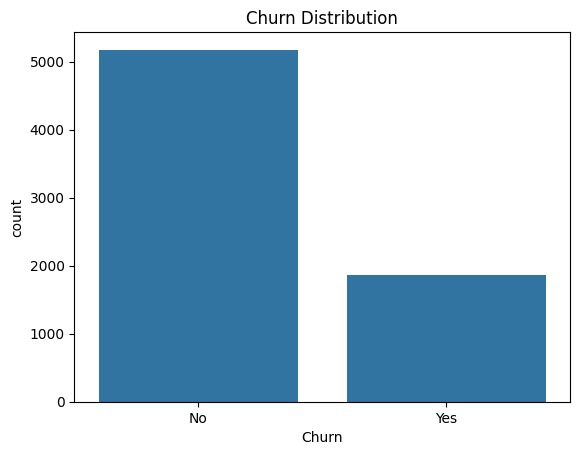

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x=df.Churn)
plt.title("Churn Distribution")

We first examine the overall distribution of churn. The churned customers occupies approximately 40% of the retained customers, which we should identify key factors associated with, build a classification model to predict and makes some plans to reduce.

##  3.2 The relationship between churn and direct variables

Instead of analyzing every variable, this exploratory analysis
focuses on "Contract", "tenure", and "MonthlyCharges".
These variables are selected because they are directly
linked to customer churn, and are actionable from a business perspective. Other variables are included in the modeling stage but are not emphasized in the exploratory data analysis because of the unconspicuous relationship with churn and the similarity with the selected variables.



###  3.2.1 Churn vs Contract 

Contract type is treated as a business-critical dimension,
as it directly reflects customer commitment and is a key lever
for retention strategies and is suitable to be grouped by. Therefore, SQL-style aggregation is
used to illustrate churn rates across contract segments.
```sql
SELECT
    Contract,
    COUNT(*) AS customers,
    AVG(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) AS churn_rate
FROM project.database.Telco-Customer-Churn
GROUP BY Contract
ORDER BY churn_rate DESC
```

Text(0.5, 1.0, 'Churn vs Contract')

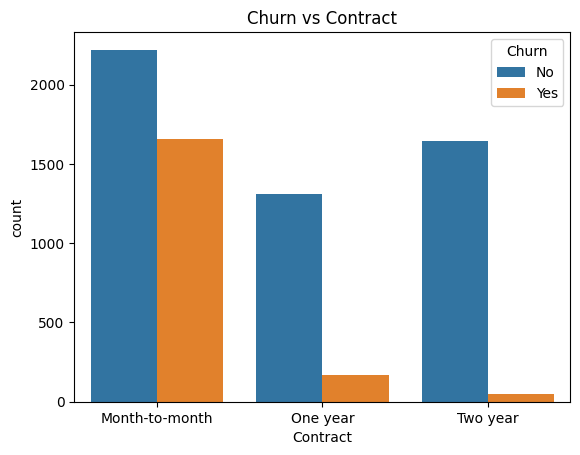

In [8]:
sns.countplot(x=df.Contract, hue=df.Churn)
plt.title("Churn vs Contract")

Contract shows a strong relationship with  churn.
Customers with month-to-month contracts exhibit significantly
higher churn rates compared to customers with long-term contracts.


###    3.2.2 Churn vs tenure

Text(0.5, 1.0, 'Churn vs tenure')

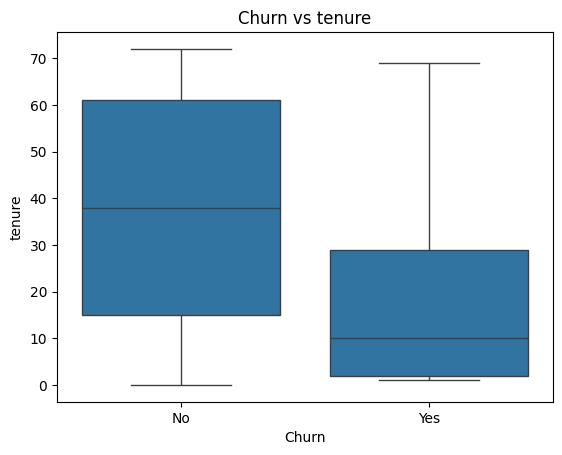

In [9]:
sns.boxplot(x=df.Churn, y=df.tenure, showfliers=False)
plt.title("Churn vs tenure")

Customers with shorter tenure are more likely to churn.
This suggests that the early stage of the customer lifecycle
is a critical period for retention efforts.


###   3.2.2 Churn vs MonthlyCharges

Text(0.5, 1.0, 'Churn vs MonthlyCharges')

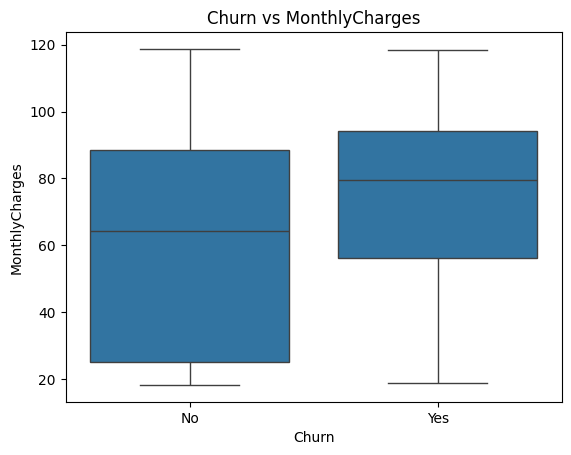

In [10]:
sns.boxplot(x=df.Churn, y=df.MonthlyCharges, showfliers=False)
plt.title("Churn vs MonthlyCharges")

Churned customers tend to have higher monthly charges on average.
This indicates potential price sensitivity among customers.

Therefore, the exploratory analysis suggests that "Contract", "tenure", and "MonthlyCharges" are strong drivers of customer churn and expected to play an important role in the predictive modeling stage.


# 4. Model Selection

##   4.1 Feature Preparation

Customer identifiers are removed as they do not provide predictive value.
The target variable is encoded as a binary outcome.
Categorical variables are converted into numerical format using one-hot encoding.


In [11]:
df = df.drop(columns="customerID")
df["Churn"] = df["Churn"].map({"Yes":1, "No":0})
df = pd.get_dummies(df)

##   4.2 Train_Test_Split

In [12]:
from sklearn.model_selection import train_test_split
X = df.drop(columns="Churn")
y = df.Churn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) 

##  4.3 Logistic Regression Model

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)
X_test_scaled = scaler.transform(X_test)
y_pred_proba_log = log_model.predict_proba(X_test_scaled)[:, 1]
auc_log = roc_auc_score(y_test, y_pred_proba_log)
print("AUC of Logistic Regression Model:", auc_log)

AUC of Logistic Regression Model: 0.8587360195010036


##  4.4 Random Forest Model

In [14]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=1)
rf_model.fit(X_train, y_train)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print("AUC of Random Forest Model:", auc_rf)

AUC of Random Forest Model: 0.8332126469744767


According to the results, AUC of logistic regression model is bigger than random forest model, motivating the use of a logistic regression model.

# 5. Feature Importance Analysis 

In [15]:
coef = pd.Series(log_model.coef_[0], index=X.columns).sort_values(key=abs, ascending=False)
coef.head(10)

tenure                           -1.514644
TotalCharges                      0.777185
MonthlyCharges                   -0.597886
InternetService_Fiber optic       0.319353
Contract_Two year                -0.311416
Contract_Month-to-month           0.285538
InternetService_DSL              -0.258969
StreamingMovies_Yes               0.143804
StreamingTV_Yes                   0.124985
PaymentMethod_Electronic check    0.112604
dtype: float64

Among the most influential features, "tenure" has the strongest negative coefficient, indicating that long-term customers are significantly less likely to churn. And although the second strongest negative coefficient is "MonthlyCharges", its coefficient should be interpreted conditionally, as its effect is moderated by customer tenure. This suggests that price sensitivity plays a stronger role in early-stage churn, while among long-tenure customers, pricing alone is less predictive of churn behavior.

In contrast, "InternetService_Fiber optic" and "Contract_Month-to-month" are associated with higher churn risk, suggesting potential price sensitivity and lower switching costs.

By the way, "TotalCharges" can be seemed under the influence of "tenure" and "MonthlyCharges" rather than a distinct causal driver of churn.

# 6.  Business Insights and Implications

##   6.1 Key Risk Drivers of Customer Churn

According to the results of feature importance analysis, shorter customer tenure, month-to-month contracts and fiber optic internet service are several key factors associated with higher churn risk.


##  6.2 High-Risk Customer Segments

Based on the identified risk drivers, several high-risk customer segments can be defined. Customers with short tenure and month-to-month contracts represent the most vulnerable group.

Additionally, fiber optic users show a higher propensity to churn, highlighting a segment that may require targeted retention efforts.


##  6.3 Business Implications

- From a business perspective, retention strategies should prioritize customers in the early stages of their lifecycle. Enhancing onboarding experiences and offering early-stage incentives may help reduce churn among new customers. 
- By giving loyalty or other rewards to encourage month-to-month customers to switch their contracts to longer-term ones to increase switching costs.
- For customers who have fiber optic users, the improvement of service's quality, fiber optic pricing adjustments, bundled service offerings could mitigate the churn of fiber optic users. 


# 7. Limitations and Future Work

##  7.1 Limitations

- This analysis is based on observational data and identifies associations rather than causal relationships. Therefore, the results should not be interpreted as evidence
that changing a specific feature will directly reduce churn.
- The dataset does not include external factors such as competitor offerings, marketing campaigns, or service outages,
which may also influence customer churn.

## 7.2 Future Work

- Future work could include customer segmentation to designmmore personalized retention strategies for different customer groups.
- Incorporating time-based modeling approaches may provide deeper insights into when customers are most likely to churn.
- Future analysis could evaluate the effectiveness of retention strategies through controlled experiments.
